In [1]:

import csv
import matplotlib as mlp
import torch.nn as nn
import numpy as np
import torch.optim as optim
import os
import random
import torch
import PIL
import pandas as pd
import cv2
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import pathlib
import torch.nn.functional as F
import glob
import matplotlib.pyplot as plt
import shutil
import matplotlib.ticker as ticker
import heapq
from collections import defaultdict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




In [2]:

# to mount to the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Assignment3/aksharantar_sampled/tel/'

/content/drive/MyDrive/Assignment3/aksharantar_sampled/tel


In [4]:
X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []

In [5]:
tsv_file = open("/content/drive/MyDrive/Assignment3/aksharantar_sampled/tel/tel_train.csv")
read_tsv = csv.reader(tsv_file)

pad1 = "\t"
space1 = "\n"
for i in read_tsv:   
    Y_train.append(i[1])
    X_train.append(i[0])

X_train = np.array(X_train)

val_tsv_file = open("/content/drive/MyDrive/Assignment3/aksharantar_sampled/tel/tel_valid.csv")
val_read_tsv = csv.reader(val_tsv_file)
pad2 = "\t"
space2 = "\n"
for i in val_read_tsv:
    Y_val.append(i[1])
    X_val.append(i[0])
X_val= np.array(X_val)

test_tsv_file = open("/content/drive/MyDrive/Assignment3/aksharantar_sampled/tel/tel_test.csv")
test_read_tsv = csv.reader(test_tsv_file)
pad3 = "\t"
space3 = "\n"
for i in test_read_tsv:
    Y_test.append(i[1])
    X_test.append(i[0])

X_test = np.array(X_test)
trainsize=len(X_train)
testsize = len(X_test)
validationsize = len(X_val)

print("Number of Training samples:", trainsize)
print("Number of Test Samples:" , testsize)
print("Number of Validation Samples:", validationsize)

Number of Training samples: 51200
Number of Test Samples: 4096
Number of Validation Samples: 4096


In [6]:
Y_train = np.array(Y_train)
for i in range(Y_train.shape[0]):
    Y_train[i] = pad1 + Y_train[i] + space1

Y_val = np.array(Y_val)
for i in range(Y_val.shape[0]):
    Y_val[i] = pad2 + Y_val[i] + space2
    
Y_test = np.array(Y_test)
for i in range(Y_test.shape[0]):
    Y_test[i] = pad3+ Y_test[i] + space3


In [7]:
traintargetsize=len(Y_train)
testtargetsize = len(Y_test)
testtargetsize = len(Y_val)
print("TrainSize of Target ",traintargetsize)
print("TrainSize of Target ",testtargetsize)
print("TrainSize of Target ",testtargetsize)


TrainSize of Target  51200
TrainSize of Target  4096
TrainSize of Target  4096


In [8]:
input_corpus = set()
output_corpus = set()
input_corpus = set(char for word in X_train for char in word if char not in input_corpus)
output_corpus = set(char for word in Y_train for char in word if char not in output_corpus)
input_corpus.add(" ")
output_corpus.add(" ")
input_corpus = sorted(list(input_corpus))
output_corpus = sorted(list(output_corpus))
val_input_corpus = set()
val_output_corpus = set()
max_encoder_seq_length = max([len(txt) for txt in X_train]) + 2
max_decoder_seq_length = max([len(txt) for txt in Y_train])

print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)
val_input_corpus = set(char for word in X_val for char in word if char not in val_input_corpus)
val_output_corpus = set(char for word in Y_val for char in word if char not in val_output_corpus)


Max sequence length for inputs: 30
Max sequence length for outputs: 21


In [9]:
num_encoder_tokens = len(input_corpus)
num_decoder_tokens = len(output_corpus)
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)

Number of unique input tokens: 27
Number of unique output tokens: 65


In [10]:


input_data = np.zeros((max_encoder_seq_length,len(X_train)), dtype="int64")
target_data = np.zeros((max_decoder_seq_length,len(X_train)), dtype="int64")
input_data_val = np.zeros((max_encoder_seq_length,len(X_val)), dtype="int64")
target_data_val = np.zeros((max_decoder_seq_length,len(X_val)), dtype="int64")

In [11]:
input_size_encoder = num_encoder_tokens
input_size_decoder = num_decoder_tokens
output_size = num_decoder_tokens


In [12]:
def create_char_index(corpus):
    char_index = defaultdict(int)
    for i, char in enumerate(corpus):
        if char not in char_index:
            char_index[char] = i
    return dict(char_index)

input_char_index = create_char_index(input_corpus)
output_char_index = create_char_index(output_corpus)

In [13]:
for i in range(len(X_train)):
    x = X_train[i]
    y = Y_train[i]
    count=0
    size = x.size
    for t, char in enumerate(x):
        input_data[t, i] = input_char_index[char]
    count=count+1 
    input_data[t + 1 :,i] = input_char_index[" "]
    count1=1
    for t, char in enumerate(y):
        target_data[t, i] = output_char_index[char]
        count1=count+1     
    target_data[t + 1 :,i] = output_char_index[" "]
    

data_type = torch.int64
data_type1=torch.float64
for i in range(len(X_val)):
    x=X_val[i]
    y=Y_val[i]
    count = 0
    size - x.size
    for t, char in enumerate(x):
        input_data_val[t, i] = input_char_index[char]
        count = count +1
    input_data_val[t + 1 :,i] = input_char_index[" "]
    
    count = 0
    for t, char in enumerate(y):
        target_data_val[t, i] = output_char_index[char]
        count = count +1
            
    target_data_val[t + 1 :,i] = output_char_index[" "]

input_data_val = torch.tensor(input_data_val,dtype=data_type)
target_data_val = torch.tensor(target_data_val,dtype=data_type)

In [14]:

input_data = torch.tensor(input_data,dtype=data_type)
reverse_input_char_index = {i: char for char, i in input_char_index.items()}
reverse_target_char_index = {i: char for char, i in output_char_index.items()}
target_data = torch.tensor(target_data,dtype=data_type)

In [15]:
#For RNN
class Seq2SeqGR(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2SeqGR, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        x = target[0]
        variables = 0
        target_vocab_size = num_decoder_tokens
        input_vocab_size = num_encoder_tokens
        outputs = torch.zeros(target.shape[0], source.shape[1], target_vocab_size).to(device)

        encoder_states, hidden = self.encoder(source)
        # Grab the first input to the Decoder which will be <SOS> token

        for t in range(1, target.shape[0]):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, _, results = self.decoder(x, encoder_states, hidden)

            # Store next output prediction
            outputs[t] = output
            res = output[0:]
            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)
            tf = teacher_force_ratio
            ran = random.random()
            if ran <  tf:
                x = target[t]
            else:
                x = best_guess

        return outputs
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout):
        super(EncoderRNN, self).__init__()
        self.dropout, self.hidden_size,self.num_layers = nn.Dropout(dropout),hidden_size,num_layers
        bidirection = True
        self.embedding, self.rnn = nn.Embedding(input_size, embedding_size),nn.RNN(embedding_size, hidden_size, num_layers, bidirectional=True)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, bidirectional=bidirection )
        hid_2 = hidden_size * 2
        self.fc_hidden , self.fc_cell = nn.Linear(hid_2, hidden_size) , nn.Linear(hid_2, hidden_size)

    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size
        a = self.embedding(x)
        embedding = self.dropout(a)

        dim_value = 2
        encoder_states, hidden = self.rnn(embedding)

        hid1 = hidden[0:1]
        hid2 = hidden[1:2]
        hid3 = torch.cat((hidden[0:1], hidden[1:2]), dim=dim_value)
        hidden = self.fc_hidden(hid3)

        return encoder_states, hidden
class DecoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout):
        super(DecoderRNN, self).__init__()
        self.dropout,self.hidden_size,self.num_layers ,self.embedding = nn.Dropout(dropout),hidden_size,num_layers, nn.Embedding(input_size, embedding_size)

        val,zero = 1,0
        hidsize =  hidden_size * 2
        hidemb = hidsize + embedding_size
        self.rnn = nn.RNN(hidemb , hidden_size, num_layers)
        hid_3 = hidden_size * 3
        self.energy, self.fc,self.softmax,self.relu = nn.Linear(hid_3, val),nn.Linear(hidden_size, output_size),nn.Softmax(dim=zero),nn.Hardshrink()


    def forward(self, x, encoder_states, hidden):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(0)
        a= self.embedding(x)
        hid = hidden.unsqueeze(0)
        embedding = self.dropout(a)
        length_seq = encoder_states.shape[0]
        # embedding shape: (1, N, embedding_size)
        val  = 2
        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(length_seq , 1, 1)
  
        concat = torch.cat((h_reshaped, encoder_states), dim=val)

        
        attention = (self.softmax(self.relu(self.energy(concat)))).permute(1,2,0)

        

        encoder_states = self.relu(encoder_states.permute(1,0,2))

        
        context_vector = torch.bmm(attention, encoder_states)
        context_vector = context_vector.permute(1,0,2)
        
        rnn_concat = torch.cat((context_vector,embedding),dim=val)
        rnn_input = rnn_concat
           # rnn_input = self.relu(rnn_input)
        outputs, (hidden) = self.rnn(rnn_input, (hidden))
            # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs)
        results = self.softmax(predictions)
        predictions = predictions.squeeze(0)

        return predictions,hidden,attention,results                                       


In [16]:
#For GRU
class Seq2SeqGR(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2SeqGR, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        x = target[0]
        variables = 0
        target_vocab_size = num_decoder_tokens
        input_vocab_size = num_encoder_tokens
        outputs = torch.zeros(target.shape[0], source.shape[1], target_vocab_size).to(device)

        encoder_states, hidden = self.encoder(source)
        # Grab the first input to the Decoder which will be <SOS> token

        for t in range(1, target.shape[0]):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, _, results = self.decoder(x, encoder_states, hidden)

            # Store next output prediction
            outputs[t] = output
            res = output[0:]
            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)
            tf = teacher_force_ratio
            ran = random.random()
            if ran <  tf:
                x = target[t]
            else:
                x = best_guess

        return outputs
class EncoderGRU(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout):
        super(EncoderGRU, self).__init__()
        self.dropout, self.hidden_size,self.num_layers = nn.Dropout(dropout),hidden_size,num_layers
        bidirection = True
        self.embedding, self.rnn = nn.Embedding(input_size, embedding_size),nn.RNN(embedding_size, hidden_size, num_layers, bidirectional=True)
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirection )
        hid_2 = hidden_size * 2
        self.fc_hidden , self.fc_cell = nn.Linear(hid_2, hidden_size) , nn.Linear(hid_2, hidden_size)

    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size
        a = self.embedding(x)
        embedding = self.dropout(a)

        dim_value = 2
        encoder_states, hidden = self.rnn(embedding)

        hid1 = hidden[0:1]
        hid2 = hidden[1:2]
        hid3 = torch.cat((hidden[0:1], hidden[1:2]), dim=dim_value)
        hidden = self.fc_hidden(hid3)
  

        return encoder_states, hidden
class DecoderGRU(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout):
        super(DecoderGRU, self).__init__()
        self.dropout,self.hidden_size,self.num_layers ,self.embedding = nn.Dropout(dropout),hidden_size,num_layers, nn.Embedding(input_size, embedding_size)

        val,zero = 1,0
        hidsize =  hidden_size * 2
        hidemb = hidsize + embedding_size
        self.rnn = nn.GRU(hidemb , hidden_size, num_layers)
        hid_3 = hidden_size * 3
        self.energy, self.fc,self.softmax,self.relu = nn.Linear(hid_3, val),nn.Linear(hidden_size, output_size),nn.Softmax(dim=zero),nn.Hardshrink()


    def forward(self, x, encoder_states, hidden):
      
        x = x.unsqueeze(0)
        a= self.embedding(x)
        hid = hidden.unsqueeze(0)
        embedding = self.dropout(a)
        length_seq = encoder_states.shape[0]

        val  = 2
        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(length_seq , 1, 1)

        concat = torch.cat((h_reshaped, encoder_states), dim=val)
        attention = (self.softmax(self.relu(self.energy(concat)))).permute(1,2,0)

        

        encoder_states = self.relu(encoder_states.permute(1,0,2))

        
        context_vector = torch.bmm(attention, encoder_states)
        context_vector = context_vector.permute(1,0,2)
        
        rnn_concat = torch.cat((context_vector,embedding),dim=val)
        rnn_input = rnn_concat

        outputs, (hidden) = self.rnn(rnn_input, (hidden))


        predictions = self.fc(outputs)
        results = self.softmax(predictions)
        predictions = predictions.squeeze(0)

        return predictions,hidden,attention,results                                       


In [17]:
dec_dropout = 0.1
num_epochs = 30
criterion = nn.CrossEntropyLoss()
decoder_embedding_size = 256
batch_size = 256
enc_dropout = 0.1
hidden_size = 512
encoder_embedding_size = 256
num_layers = 1
beam_width=2
learning_rate=0.001


In [18]:

import heapq
#     return word_t
def beam_findGR(model, word, norm,input_char_index, output_char_index, reverse_input_char_index,
                reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length,
                num_encoder_tokens, num_decoder_tokens, beam_width, device, total_words,length_penalty=0.6):

    word_t = ''

    word_val = 0
    attention = []
    data = np.zeros((max_encoder_seq_length, 1), dtype="int64")
    datatype = torch.int64
    for t in range(len(word)):
        char = word[t]
        data[t, word_val] = input_char_index[char]
    word_size =len(word)
    data[ word_size:, word_val] = input_char_index[" "]
    data = torch.tensor(data, dtype=datatype).to(device)

    with torch.no_grad():
        encoder_states,hidden = model.encoder(data)

    # Initialize beam
    
    value = 1
    ovalue=-1
    padding = '\t'
    initial_sequence = torch.tensor(np.array(output_char_index[padding]).reshape(value,)).to(device)
    zero = 0
    res =hidden.unsqueeze(0)
    beam = [(0.0, initial_sequence, hidden.unsqueeze(0))]  # [(score, sequence, hidden)]
    start ='\n'
    for _ in range(max_decoder_seq_length):
        candidates = []
        options=[]
        for score, seq, hidden in beam:
            count = 0
            last_token = seq[ovalue].item()
            if last_token == output_char_index[start]:
                # If the sequence ends with the end token, add it to the candidates
                candidates.append((score, seq, hidden))
                count =count+1
                continue
            tempval = np.array(last_token).reshape(value,)
            x = torch.tensor(tempval).to(device)
            output, hidden,at,res = model.decoder(x,encoder_states ,hidden.squeeze(0))
            attention.append(at.detach().cpu().numpy())
            res = output[0:]
            probabilities = F.softmax(output, dim=1)
            result =probabilities
            # Get the top-k probabilities and tokens
            topk_probs, topk_tokens = torch.topk(probabilities, k=beam_width)
            tops = topk_probs[0]
            topk = topk_tokens[0]
            for prob, token in zip(tops, topk):
                new_s= token.unsqueeze(0)
                new_seq = torch.cat((seq, new_s), dim=0)
                new_hidden = hidden.clone().unsqueeze(0)
                penalty = len(new_seq) - 1
                len_pen = length_penalty
                length_penalty_factor = ((penalty) / 5) **  len_pen   # Adjust penalty factor as needed
                candidates.append((score + torch.log(prob).item() / length_penalty_factor, new_seq, new_hidden))
                options.append((score + torch.log(prob).item() / length_penalty_factor))
        # Select top-k candidates based on the accumulated scores
        beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[0])

    # Select the best sequence from the beam as the output
    best_res = ""
    best_score, best_sequence, _ = max(beam, key=lambda x: x[zero])
    word_t = ''.join([reverse_target_char_index[token.item()] for token in best_sequence[value:ovalue]])
    best_res = word_t

    return word_t,attention


In [19]:
input_size_enc = input_size_encoder
enc_embedding_size = encoder_embedding_size
hidden_size_enc =  hidden_size
num_layers_enc = 1
dropout_enc =  enc_dropout
encoder_net = EncoderGRU(input_size_enc,enc_embedding_size, hidden_size_enc, num_layers_enc, dropout_enc).to(device)

input_size_dec = input_size_decoder
dec_embedding_size = decoder_embedding_size
hidden_size_dec =  hidden_size
num_layers_dec = 1
dropout_dec =  dec_dropout
decoder_net = DecoderGRU( input_size_dec,dec_embedding_size,hidden_size_dec,output_size,num_layers_dec,dropout_dec,).to(device)

model = Seq2SeqGR(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:

data_train = torch.split(input_data,batch_size,dim=1)
target_train = torch.split(target_data,batch_size,dim=1)
for epoch in range(num_epochs):
    correct_pred = 0
    print(f"[Epoch {epoch} / {num_epochs}]")

    model.eval()
    model.train()
    trainsize = len(data_train)
    for i in range(trainsize):
          neg = -1
          pos = 1
          x = data_train[i]
          y = target_train[i]
          # Get input and targets and get to cuda
          inp_data = x.to(device)
          target = y.to(device)

          # Forward prop
          output = model(inp_data, target)
          size = output.shape[2]
          temp = output[pos:]
          temp1 =temp.reshape(neg, size)
          output = temp1
          tar = target[pos:]
          target = tar.reshape(neg)

          optimizer.zero_grad()
          loss = criterion(output, target)

          # Back prop
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            # Gradient descent step
          optimizer.step()
    total_words_test = len(X_test)
    model.eval()
    total_words = len(X_val)
    correct_prediction = 0
    for i in range(total_words):

        decoded_sentence,_ = beam_findGR(model,X_val[i], 10,input_char_index, output_char_index, reverse_input_char_index, 
        reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
        num_encoder_tokens, num_decoder_tokens,3,device,total_words)
        true_output  = Y_val[i][1:-1]
        if true_output== decoded_sentence:
            correct_prediction = correct_prediction + 1
#print(decoded_sentence)
#print('\n')
    test_accuracy = correct_prediction / total_words

    print(test_accuracy)


[Epoch 0 / 30]
0.24462890625
[Epoch 1 / 30]
0.388671875
[Epoch 2 / 30]
0.45458984375
[Epoch 3 / 30]
0.48193359375
[Epoch 4 / 30]
0.505615234375
[Epoch 5 / 30]
0.50830078125
[Epoch 6 / 30]
0.516357421875
[Epoch 7 / 30]
0.52294921875
[Epoch 8 / 30]
0.52734375
[Epoch 9 / 30]
0.489990234375
[Epoch 10 / 30]
0.522705078125
[Epoch 11 / 30]
0.515625
[Epoch 12 / 30]
0.523193359375
[Epoch 13 / 30]
0.5185546875
[Epoch 14 / 30]
0.517822265625
[Epoch 15 / 30]
0.525634765625
[Epoch 16 / 30]
0.533203125
[Epoch 17 / 30]
0.524658203125
[Epoch 18 / 30]
0.516845703125
[Epoch 19 / 30]
0.523193359375
[Epoch 20 / 30]
0.518798828125
[Epoch 21 / 30]
0.521240234375
[Epoch 22 / 30]
0.519775390625
[Epoch 23 / 30]
0.522705078125
[Epoch 24 / 30]
0.51806640625
[Epoch 25 / 30]
0.520263671875
[Epoch 26 / 30]
0.515380859375
[Epoch 27 / 30]
0.521728515625
[Epoch 28 / 30]
0.51904296875
[Epoch 29 / 30]
0.514892578125


In [21]:
input = []
correct = []
decoded = []
ex = []

In [30]:
from matplotlib.font_manager import FontProperties

# function for plotting the attention weights
def plot_attention(attention,wordsize,word_tsize, sentence, predicted_sentence, fig, seq_index, word, word_t):


    cmap='PuRd'    
    ax = fig.add_subplot(4, 3, seq_index)
    minvalue = 0 
    maxvalue = 1
    cax = ax.matshow(attention, cmap=cmap, vmin = minvalue, vmax = maxvalue)

    fontsize  = 20
    font_prop_x = FontProperties(size=fontsize )
    font_prop_y = FontProperties(fname="/content/drive/MyDrive/Assignment3/aksharantar_sampled/tel/AnekTelugu[wdth,wght].ttf", size=fontsize )

    lis=['']
    real = lis + sentence
    pred = lis + predicted_sentence
    ax.set_xticklabels(real,  fontproperties=font_prop_x)
    ax.set_yticklabels(pred, fontproperties=font_prop_y)    
    fig.colorbar(cax)

In [33]:


def plot_heatmap(model, word, input_char_index, output_char_index, reverse_input_char_index, reverse_target_char_index, 
                 max_encoder_seq_length, max_decoder_seq_length, num_encoder_tokens, num_decoder_tokens, device, fig, seq_index,correct):
    word_t, at = beam_findGR(model,word, 10,input_char_index, output_char_index, reverse_input_char_index, 
                 reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
                 num_encoder_tokens, num_decoder_tokens,3,device,100)
    attention = []
    input_set = []
    output_set = []
    for i in word:
        input_set.append(i)
    for i in word_t:
        output_set.append(i)
    cor = 0
    for i in at:
        attention.append(i.reshape(30,))
        cor = cor + 1
    attention = np.array(attention)
    print('Input : ' + word)
    print('Output : ' + word_t)    
    print('Correct Output : ' + correct[1:-1])
    if(word_t==correct[1:-1]):
      print("Output Matches")
    else:
      print("Output Not Matches")



        

    plot_attention(attention[0:len(word_t),0:len(word)],len(word_t), len(word),input_set, output_set, fig, seq_index, word, word_t)

Input : chebutunnaamane
Output : చెబుతున్నామనే
Correct Output : చెబుతున్నామనే
Output Matches


Input : vishnuvu
Output : విష్ణువు
Correct Output : విష్ణువు
Output Matches


<ipython-input-30-46373c08c8a4>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(real,  fontproperties=font_prop_x)
<ipython-input-30-46373c08c8a4>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(pred, fontproperties=font_prop_y)




Input : andaalanu
Output : అందాలను
Correct Output : అందాలను
Output Matches


Input : praadhaanyangaa
Output : ప్రాధాన్యంగా
Correct Output : ప్రాధాన్యంగా
Output Matches


Input : haokip
Output : హోకీప్
Correct Output : హాకీప్
Output Not Matches


Input : cholera
Output : చోలేరా
Correct Output : కలరా
Output Not Matches


Input : aidellugaa
Output : ఐదేళ్ళుగా
Correct Output : ఐదేళ్లుగా
Output Not Matches


Input : bayonne
Output : బయోన్నే
Correct Output : బెయోన్
Output Not Matches


Input : pattanaalaku
Output : పట్టణాలకు
Correct Output : పట్టణాలకు
Output Matches


Input : aagakumdaa
Output : ఆగకుండా
Correct Output : ఆగకుండా
Output Matches




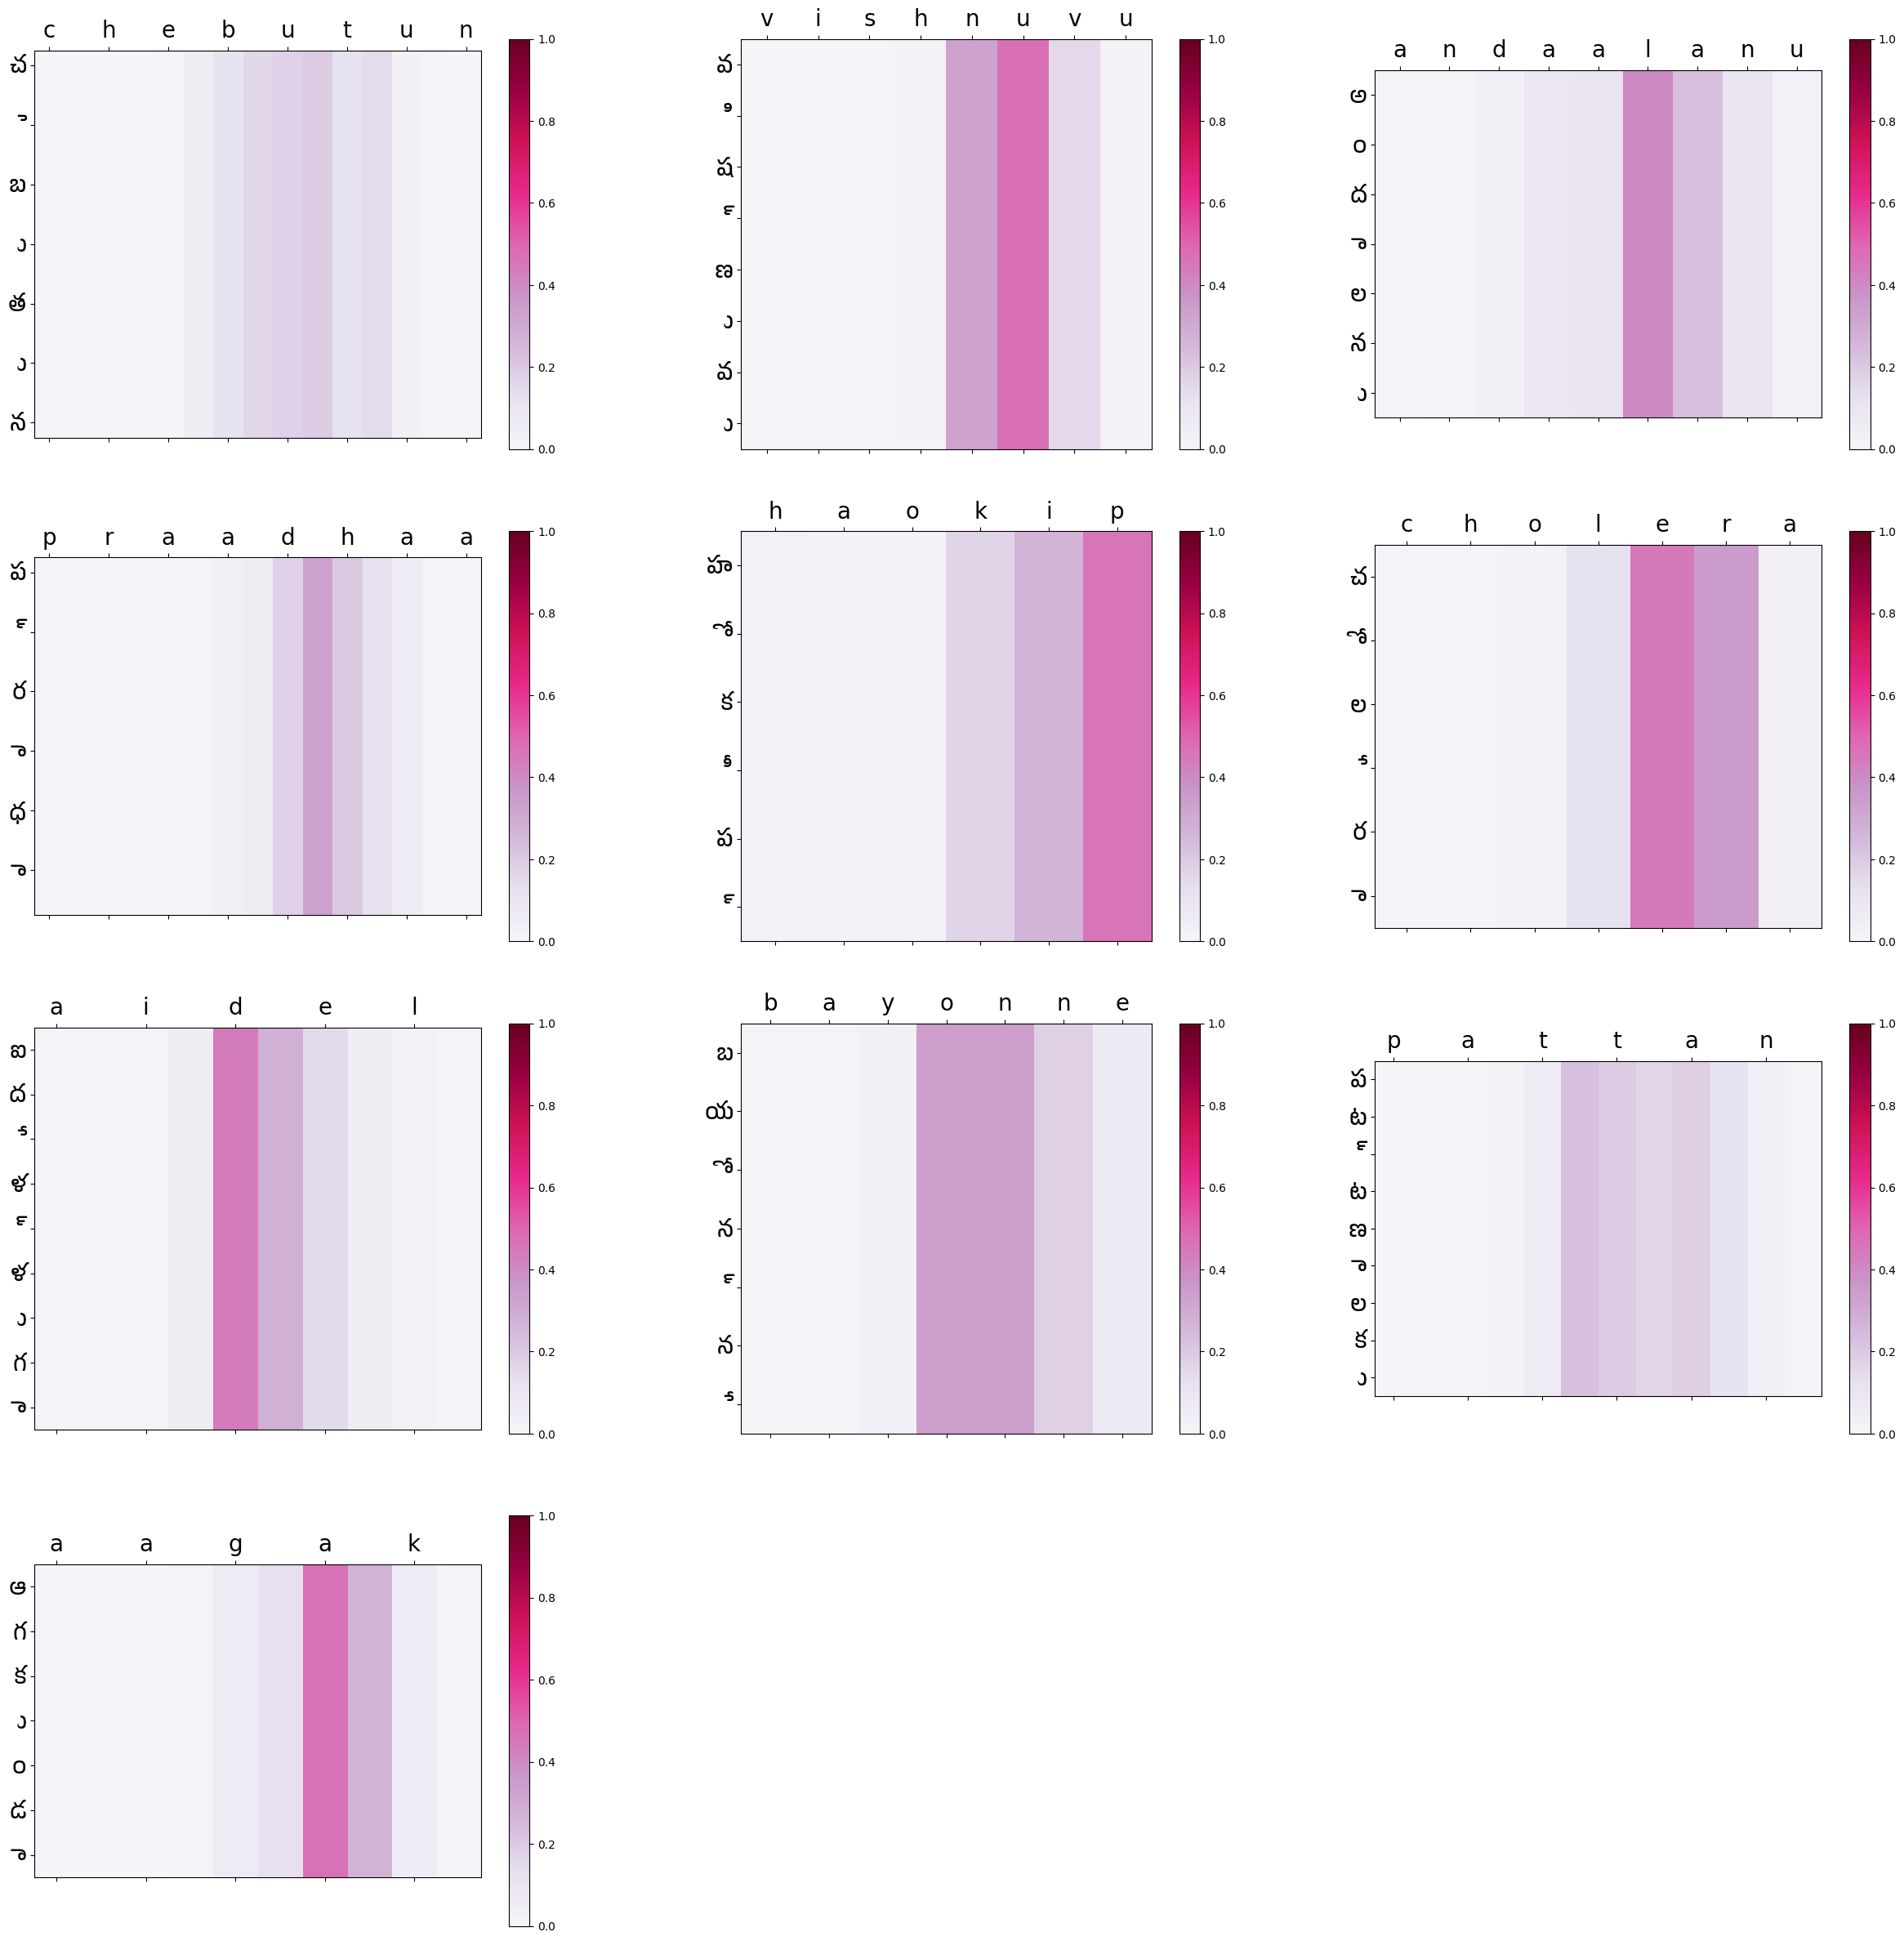

In [34]:
np.random.seed(10)
fig = plt.figure(figsize=(30, 30))
count = 0
while(count<10):
    seq_index = random.randint(0,4096)
    input_seq = X_test[seq_index]
    output_seq = Y_test[seq_index]
    plot_heatmap(model, input_seq, input_char_index, output_char_index, reverse_input_char_index, 
              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
              num_encoder_tokens, num_decoder_tokens, device, fig, count+1,output_seq )
    count = count + 1
    print("\n")

In [25]:
total_words = len(X_test)
correct_prediction = 0 
corr = 0
for i in range(total_words):

    decoded_sentence,_ = beam_findGR(model,X_test[i],10, input_char_index, output_char_index, reverse_input_char_index, 
                        reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
                       num_encoder_tokens, num_decoder_tokens,1,device,100)
    true_result = Y_test[i][1:-1]
    if  true_result== decoded_sentence:
            correct_prediction = correct_prediction +  1
    corr =correct_prediction
test_accuracy = correct_prediction / total_words
print("Test Accuracy is :")
print(test_accuracy)


Test Accuracy is :
0.47900390625


In [26]:
counttrue = 0 
countfalse = 0
np.random.seed(10)
for index in range(total_words):
     pos = 1
     npos = -1
     decoded_sentence,_ = beam_findGR(model,X_test[index],10, input_char_index, output_char_index, reverse_input_char_index, 
              reverse_target_char_index, max_encoder_seq_length, max_decoder_seq_length, 
              num_encoder_tokens, num_decoder_tokens,1,device,100)
     true_output = Y_test[index][pos:npos]
     if true_output == decoded_sentence:
                counttrue = counttrue + 1
                ex.append("Yes")
     else:
                countfalse = countfalse + 1
                ex.append("No")        
     #print(decoded_sentence)  
     real_input = X_test[index]
     input.append(real_input)
     real_output = true_output
     correct.append(real_output)
     decoded_output = decoded_sentence
     decoded.append(decoded_output)
import pandas as pd

grid = {'True Input': input, 'True Output' : correct, 'My Decoded Output' : decoded, "Matching or Not" : ex}
        #print(grid)
df=pd.DataFrame(grid)
        #df= pd.DataFrame.from_dict(grid,orient='index')
df.to_csv('/content/drive/MyDrive/Assignment3/aksharantar_sampled/tel/attdec.csv', index=False,header=True)
#print(df.head(20))
pd.DataFrame(grid)

,True Input,True Output,My Decoded Output,Matching or Not
0,vithananni,విత్తనాన్ని,వితనన్ని,No
1,prayaanikulu,ప్రయాణికులు,ప్రయాణికులు,Yes
2,hassan,హసన్,హస్సన్,No
3,pakshala,పక్షాల,పక్షల,No
4,goutham,గౌతమ్,గౌతం,No
...,...,...,...,...
4091,kukie,కుకీ,కుకీయ్,No
4092,mosaginchadam,మోసగించడం,మోసగించడం,Yes
4093,telamgaanha,తెలంగాణ,తెలంగాణ,Yes
4094,patel,పటేల్,పటెల్,No
